In [ ]:
#!pip install -U scikit-learn
#!pip install autograd

In [1]:
!python3 --version

Python 3.9.1


# 1st Assignment: NN's from Scratch 

By: Jan Leyva Massagué

The objective is to build from scratch a neural network to perform  classification. Let's first consider the follwing 2-class dataset:

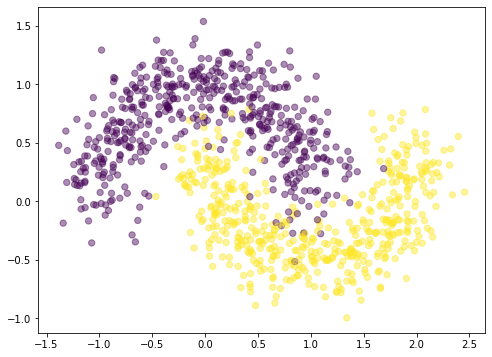

In [110]:
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import plotly.graph_objects as go
from sklearn import metrics
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns



n = 1000

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(n, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45)

In [72]:
# Function to plot Confusion Matrix
def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, \
                     fmt=fmt, cmap=plt.cm.Blues, ax=ax) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(confusion_matrix(yTrue, yEst), classes, title, fmt, ax, xlabel='Estimations', \
                ylabel='True values');
    print("Accuracy:", round(accuracy_score(yTrue, yEst)*100, 2), "%")

We will use a **3-layer classification neural network** with one input layer, one hidden layer, and one output layer. 

The number of nodes in the input layer will be determined by the dimensionality of our data (2). Similarly, the number of nodes in the output layer is determined by the number of classes $C$ we have (also 2). 

Our network makes predictions using forward propagation, which is just a bunch of matrix multiplications and the application of the activation function $\sigma$. 

If $x$ is the input to our network then we calculate our prediction $\hat{y}$ as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \sigma(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ y = \mbox{softmax}({z_2})$$

where $y$ is a multidimensional vector representing a probability distribution over classes, $\sigma$ is a non linear function and $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of the parameters $W$ as matrices transforming data between layers of the network. 

Looking at the matrix multiplications above we can figure out the dimensionality of these matrices in our problem. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. 

The last layer is a `softmax` function. The softmax function is a generalization of the logistic function to multiple dimensions. It is used to normalize the output of a network to a probability distribution over predicted output classes.

The softmax function takes as input a vector $C$ of real numbers, and normalizes it into a probability distribution consisting of $C$ probabilities proportional to the exponentials of the input numbers:

$$softmax(z_i) = \frac{exp(z_i)}{\sum_{j=1}^{C}exp(z_j))}$$

A common choice with the softmax output is the **cross-entropy loss**. If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

In [4]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

# Gradient descent parameters 
epsilon = 0.03 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

### Model 1: 1 hidden layer + tanh

In [74]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [75]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
        if i == (num_passes-1):
            print("End of the trainning process") 
    return model

In [7]:
# Build a model with a 3-dimensional hidden layer
modelV1 = build_model(3, print_loss=False)

End of the trainning process


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

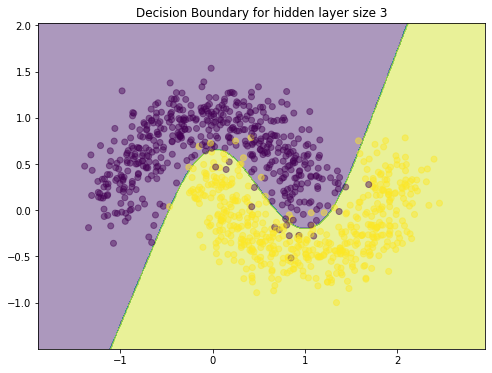

In [8]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

    
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(modelV1, x))
plt.title("Decision Boundary for hidden layer size 3")

Accuracy: 96.8 %


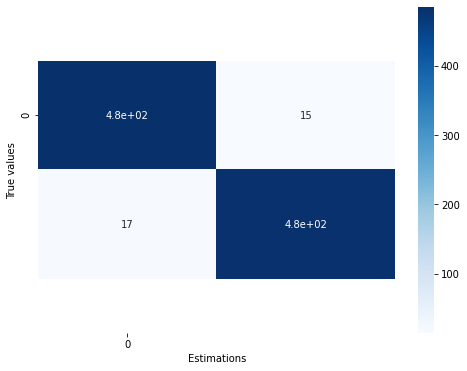

In [76]:
pred = predict(modelV1, X)
plotConfusionMatrix(y, pred, classes = 2)

# Exercise 1

Add an additional layer to your neural network model. Change the activation function and use a ReLU. Does it work?


## First we will try with an additional layer

### Model 2: 2 hidden layer + tanh

In [117]:
# loss function for a 4-layer MLP
def loss(model):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)              # changed the activation function to `ReLU`
    z2 = np.dot(a1,W2) + b2
    a2 = sigma(z2)              # changed the activation function to `ReLU`
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2))) + np.sum(np.square(W3))
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)              # changed the activation function to `ReLU`
    z2 = np.dot(a1,W2) + b2
    a2 = sigma(z2)              # changed the activation function to `ReLU`
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [118]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_hdim))
    W3 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b3 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model

In [119]:
# Build a model with a 3-dimensional hidden layer
model_4layers = build_model(3, print_loss=False)

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

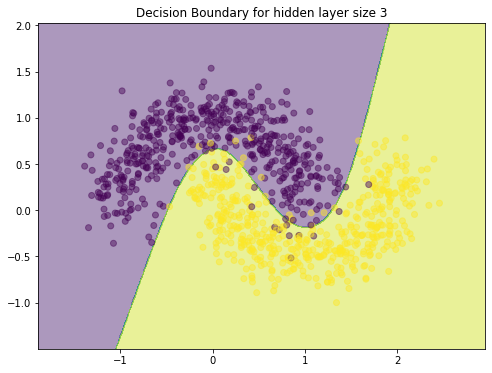

In [32]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model_4layers, x))
plt.title("Decision Boundary for hidden layer size 3")

Accuracy: 96.9 %


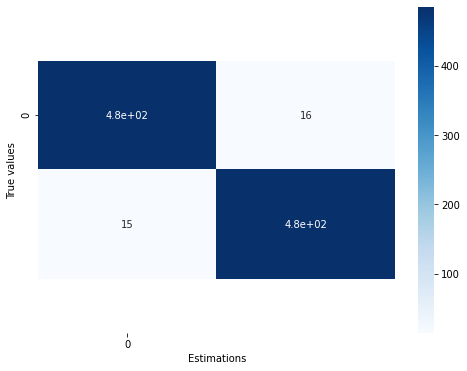

In [80]:
pred_4layers = predict(model_4layers, X)
plotConfusionMatrix(y, pred_4layers, classes = 2)

##  Now we going to check what happen if we change the activation function to ReLU

Parametric ReLUs (PReLUs) take this idea further by making the coefficient of leakage into a parameter that is learned along with the other neural-network parameters.

\begin{cases}x&{\text{if }}x>0,\\ax&{\text{otherwise}}.\end{cases}


otherwise:


Note that for a ≤ 1, this is equivalent to

$$f(x)=\max(x,ax)$$

And we going to applt:

$$f(x)=\max(0, x)$$

We definde as:

In [35]:
def reLU(x):
    x = np.maximum(0, x)
    return x

### Model 3: 2 hidden layer + ReLU

In [128]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = reLU(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = reLU(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [129]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
        if i == (num_passes-1):
            print("End of the trainning process") 
    return model

In [130]:
# Build a model with a 3-dimensional hidden layer
model_ReLU1 = build_model(3, print_loss=False)

End of the trainning process


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

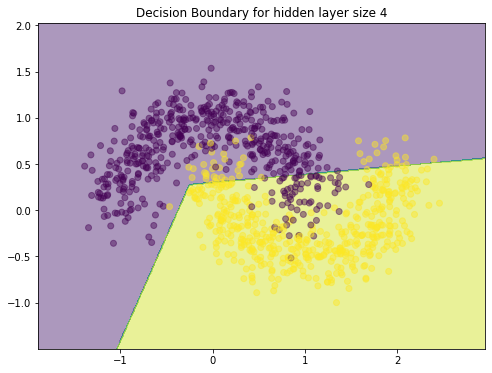

In [133]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model_ReLU1, x))
plt.title("Decision Boundary for hidden layer size 4")

Accuracy: 88.7 %


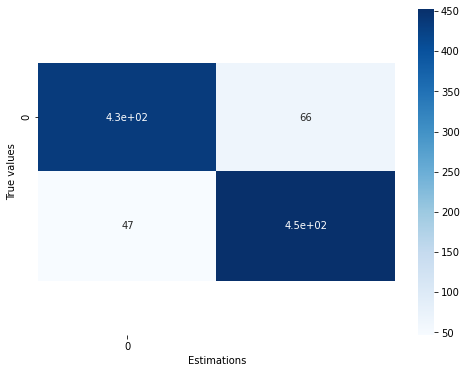

In [134]:
pred_ReLU1 = predict(model_ReLU1, X)
plotConfusionMatrix(y, pred_ReLU1, classes = 2)

### Model 4: 2 hidden layer + ReLU

In [112]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = reLU(z1)              # changed the activation function to `ReLU`
    z2 = np.dot(a1,W2) + b2
    a2 = reLU(z2)              # changed the activation function to `ReLU`
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2))) + np.sum(np.square(W3))
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    z1 = np.dot(x,W1) + b1
    a1 = reLU(z1)              # changed the activation function to `ReLU`
    z2 = np.dot(a1,W2) + b2
    a2 = reLU(z2)              # changed the activation function to `ReLU`
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [124]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_hdim))
    W3 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b3 = np.zeros((1, nn_output_dim))
 
    
    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
        if i == (num_passes-1):
            print("End of the trainning process") 
            
    return model

In [125]:
# Build a model with a 3-dimensional hidden layer
model_ReLU = build_model(3, print_loss=False)

End of the trainning process


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

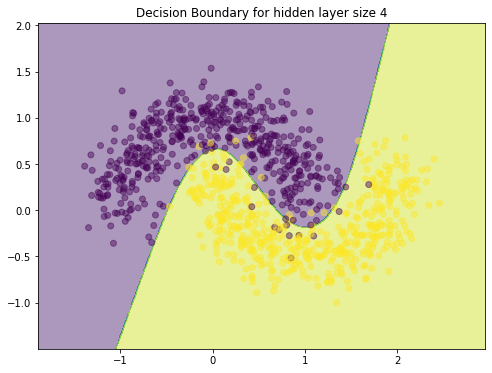

In [127]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model_ReLU, x))
plt.title("Decision Boundary for hidden layer size 4")

Accuracy: 96.9 %


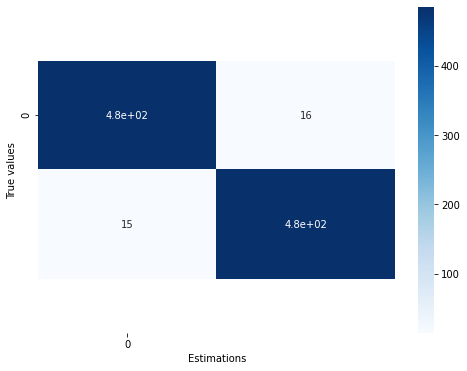

In [126]:
pred_ReLU = predict(model_ReLU, X)
plotConfusionMatrix(y, pred_ReLU, classes = 2)

### Summary Table

In this section are summary the metrics and architecture of the three different **NN**:

In [85]:
# Calc the accuracy for each architecture
acc_1tanh = accuracy_score(y, pred)
acc_2tanh = accuracy_score(y, pred_4layers)
acc_reLU = accuracy_score(y, pred_ReLU)


fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Accuracy']),
                 cells=dict(values=[["1-hd + tanh", "2-hd + tanh", "2-hd + ReLU"], [acc_1tanh, acc_2tanh, acc_reLU]]))
                     ])
fig.show()

In [141]:
# Calc the accuracy for each architecture
acc_1tanh = accuracy_score(y, pred)
acc_2tanh = accuracy_score(y, pred_4layers)
acc_1reLU = accuracy_score(y, pred_ReLU1)
acc_2reLU = accuracy_score(y, pred_ReLU)


fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'nº hidden layers', 'Activation function','Accuracy']),
                 cells=dict(values=[["Model 1", "Model 2", "Model 3", "Model 4"], [1, 2 , 1, 2], ['tanh', 'tanh', 'ReLU', 'ReLU'],
                                    [acc_1tanh, acc_2tanh, acc_1reLU, acc_2reLU]]))
                     ])

fig.show()

# Exercise 2

Design (change parameters) and train a NN to classify the following dataset. 

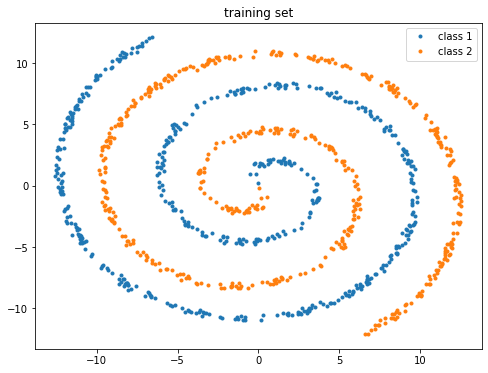

In [94]:
import numpy
import matplotlib.pyplot as plt

def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = numpy.sqrt(numpy.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -numpy.cos(n)*n + numpy.random.rand(n_points,1) * noise
    d1y = numpy.sin(n)*n + numpy.random.rand(n_points,1) * noise
    return (numpy.vstack((numpy.hstack((d1x,d1y)),numpy.hstack((-d1x,-d1y)))), 
            numpy.hstack((numpy.zeros(n_points),numpy.ones(n_points))))

X, y = twospirals(500)

y = y.astype(int)


plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

## Approach for spiral data set

This dataset is hard to classify due to the non linearity of the two groups. The approach by **NN** will have `ReLU` activation function and two hidden layer of 8 neurns each one. As well, we doing to change the `epsilon` = 0.03 and 
`reg_lambda` = 0.01. Also the number of iterations are reach to 100000.

In [96]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = reLU(z1)              # changed the activation function to `ReLU`
    z2 = np.dot(a1,W2) + b2
    a2 = reLU(z2)              # changed the activation function to `ReLU`
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2))) + np.sum(np.square(W3))
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    z1 = np.dot(x,W1) + b1
    a1 = reLU(z1)              # changed the activation function to `ReLU`
    z2 = np.dot(a1,W2) + b2
    a2 = reLU(z2)              # we try to change the second act f(x) as linear
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [97]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=100000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(1)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
    W3 = np.random.randn(nn_output_dim, nn_output_dim) / np.sqrt(nn_output_dim)
    b3 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
        if i == (num_passes-1):
            print("End of the trainning process") 
            
    return model

In [98]:
# Build a model with a 3-dimensional hidden layer
model_Spiral = build_model(8, print_loss=False)

End of the trainning process


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 8')

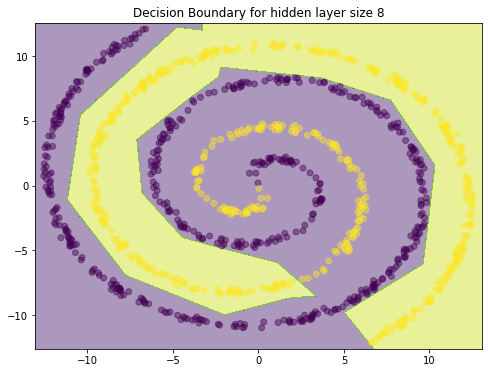

In [100]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model_Spiral, x))
plt.title("Decision Boundary for hidden layer size 8")

Accuracy: 85.5 %


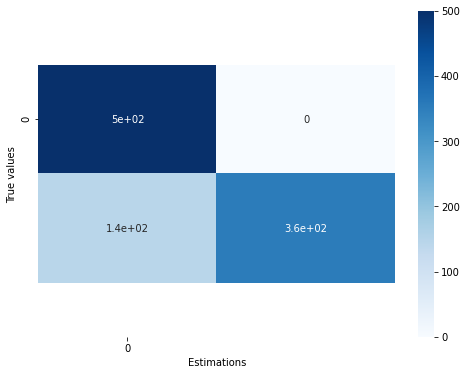

In [99]:
pred_Spiral = predict(model_Spiral, X)
plotConfusionMatrix(y, pred_Spiral, classes = 2)